In [28]:
# !pip install seaborn


In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import re

In [30]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  360
Number of subjects who completed the second session:  171


## Acquire thresholds for all tasks

### Functions:

In [31]:
def checkIfComplete(mainOutput):
    
    complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
    complete_bool = str(complete_val) == 'True'
    if not complete_bool:
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
    assert complete_bool, 'Fatal: experiment not complete!'                        

In [ ]:
def get_rsvp_responses(mydir, files): 
    
    all_data = []
    
    numSess = len(files)
    

    for sess in range(numSess):
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        # checkIfComplete(mainOutput)

        dictionary_resp_accuracy = {}
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        
        # Select rows where conditionName contains the RSVP foveal prefix
        condition_data = mainOutput[mainOutput['conditionName'].str.contains('rsvp_foveal_block', na=False)]
        # Keep only the relevant columns
        condition_data = condition_data[['rsvpReadingWordDurationSec', 'rsvpReadingResponsesBool']]
        # Drop rows where either column is NA
        condition_data = condition_data.dropna(subset=['rsvpReadingWordDurationSec', 'rsvpReadingResponsesBool']).reset_index(drop=True)
            
        threshold_per_trial = condition_data['rsvpReadingWordDurationSec']
        rsvp_responses = condition_data['rsvpReadingResponsesBool']
        if len(rsvp_responses) != len(threshold_per_trial):
            print(f'rsvp_responses length: {len(rsvp_responses)},\nthreshold_per_trial length: {len(threshold_per_trial)},\nfilename: {files[sess]}')
            assert len(rsvp_responses) == len(threshold_per_trial), "Mismatch in lengths of responses and thresholds"



        # Split each response string like '1,1,1' into three parts and store as a matrix
        resp_list = []
        for resp in rsvp_responses:
            if pd.isna(resp):
                # represent missing as [np.nan, np.nan, np.nan]
                resp_list.append([np.nan, np.nan, np.nan])
                continue
            # ensure it's a string and strip whitespace
            resp_str = str(resp).strip()
            parts = [p.strip() for p in resp_str.split(',')]
            # If fewer than 3 parts, pad with NaN; if more, truncate
            parts = parts[:3] + [np.nan] * max(0, 3 - len(parts))
            # convert to numeric where possible
            numeric_parts = []
            for p in parts:
                try:
                    numeric_parts.append(int(p))
                except Exception:
                    try:
                        numeric_parts.append(float(p))
                    except Exception:
                        numeric_parts.append(np.nan)
            resp_list.append(numeric_parts)

        # Convert to numpy matrix (rows=trials, cols=3)
        if len(resp_list) > 0:
            resp_matrix = np.array(resp_list)
        else:
            resp_matrix = np.empty((0, 3))

        # simple check: warn if fewer than expected trials
        if resp_matrix.shape[0] < 24:
            print(f"Warning: fewer than 24 trials ({resp_matrix.shape[0]}), prolificID: {prolificID}")

        resp_accuracy_per_trial = np.nansum(resp_matrix, axis=0) / resp_matrix.shape[0] * 100

        dictionary_resp_accuracy['prolificID'] = prolificID
        # dictionary_resp_accuracy['duration'] = threshold_per_trial
        dictionary_resp_accuracy['firstWord'] = resp_accuracy_per_trial[0]
        dictionary_resp_accuracy['secondWord'] = resp_accuracy_per_trial[1]
        dictionary_resp_accuracy['thirdWord'] = resp_accuracy_per_trial[2]

        # dictionary_resp_accuracy['rsvp_response_matrix'] = resp_matrix.tolist()

        all_data.append(dictionary_resp_accuracy)

        # all_data.append(subj_thresholds)
    
    all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


### Acquire thresholds:

- letter acuity (log deg)
- crowding acuity (log deg)
- RSVP reading speed (word duration, log sec)
- ordinary reading speed (words per min)

In [60]:
# first session
df_firstSess_rsvp = get_rsvp_responses(dir_firstSess, files_firstSess)


In [61]:
# second session

df_secondSess_rsvp = get_rsvp_responses(dir_secondSess, files_secondSess)


In [62]:
display(df_firstSess_rsvp.head())

,prolificID,duration,firstWord,secondWord,thirdWord
0,5f0788c06b220f03231666a0,0 2.263346 1 2.263346 2 0.200936 3...,100.0,76.0,48.0
1,64837ba51422d817b62cc5cc,0 2.263346 1 2.263346 2 0.200936 3...,100.0,76.0,80.0
2,6778842e3f7e2e62756f7178,0 2.263346 1 2.263346 2 0.200936 3...,96.0,92.0,72.0
3,669c13abec22054c1cce02e2,0 2.263346 1 2.263346 2 0.200936 3...,96.0,88.0,60.0
4,5e57d38b533eec1818078f0b,0 2.263346 1 2.263346 2 0.200936 3...,84.0,76.0,52.0


In [52]:
def plot_rsvp_word_accuracy_histograms(df_rsvp_responses):
    # Plot histograms for first, second, and third word accuracy, with mean, median, geometric mean
    bins = np.linspace(0, 100, 11)
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(['firstWord', 'secondWord', 'thirdWord']):
        plt.subplot(1, 3, i+1)
        data = df_rsvp_responses[col].dropna()
        plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col} accuracy')
        plt.xlabel('Accuracy (%)')
        plt.ylabel('Count')
        plt.xlim(0, 100)
        plt.yscale('log')
        plt.ylim(1, 150)
        # Calculate statistics
        mean_val = np.mean(data)
        median_val = np.median(data)
        # For geometric mean, filter out zeros and negatives
        geo_data = data[data > 0]
        if len(geo_data) > 0:
            geom_mean_val = stats.gmean(geo_data)
            plt.axvline(geom_mean_val, color='green', linestyle=':', label='Geometric Mean')
        else:
            geom_mean_val = np.nan
        plt.axvline(mean_val, color='red', linestyle='--', label='Mean')
        plt.axvline(median_val, color='purple', linestyle='-', label='Median')
        # Only show legend on first subplot
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

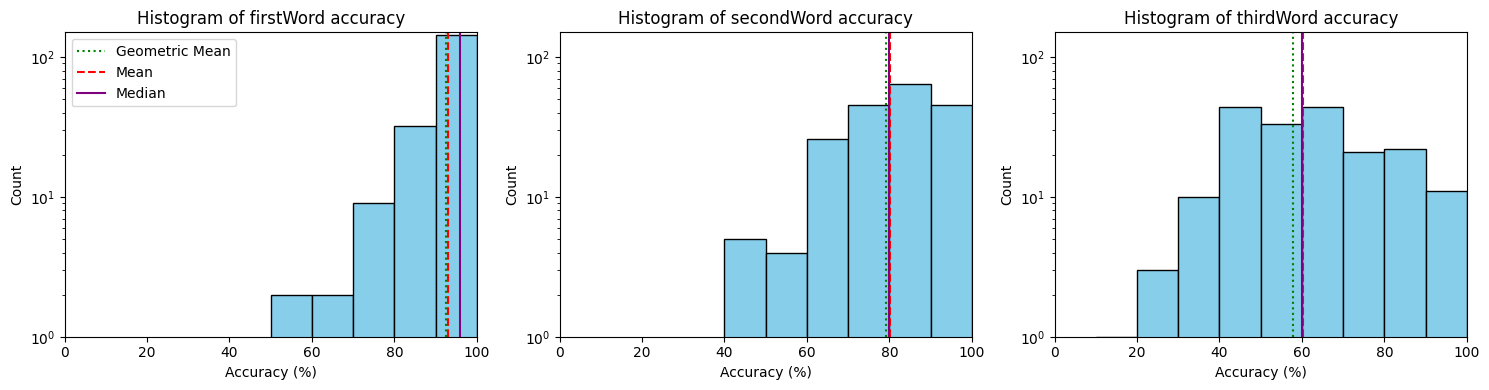

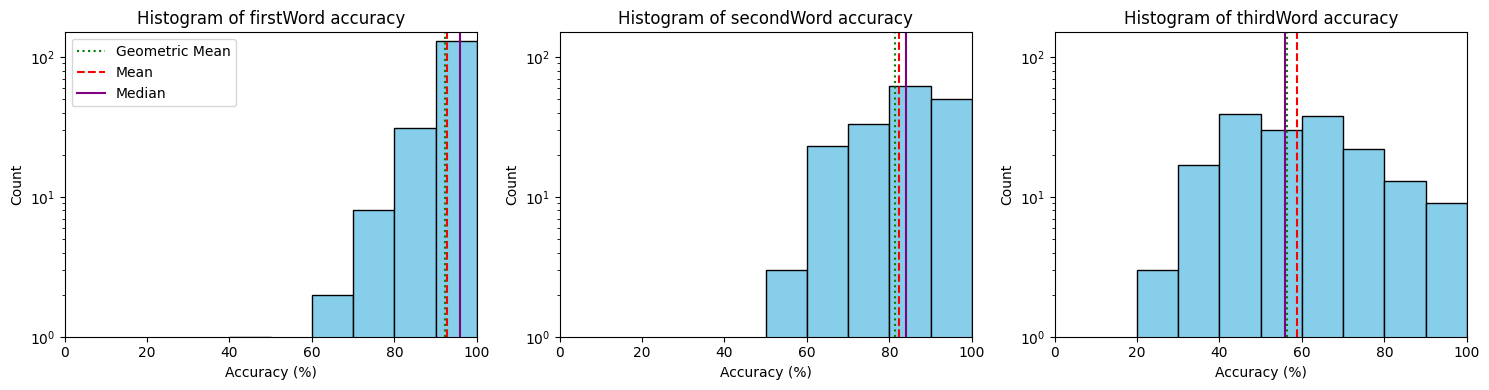

In [53]:
plot_rsvp_word_accuracy_histograms(df_firstSess_rsvp)
plot_rsvp_word_accuracy_histograms(df_secondSess_rsvp)

In [75]:
def plot_rsvp_word_accuracy_line(df_rsvp_responses):
    # Plot a line for each participant: X=word position, Y=accuracy, with horizontal jitter for dots
    plt.figure(figsize=(6, 6))
    x_labels = ['First Word', 'Second Word', 'Third Word']
    x = np.arange(3)
    rng = np.random.default_rng(42)  # for reproducibility
    for idx, row in df_rsvp_responses.iterrows():
        y = [row['firstWord'], row['secondWord'], row['thirdWord']]
        # Add small random horizontal jitter to each dot
        #jitter = rng.normal(0, 0.03, size=3)
        jitter = 0
        plt.plot(x + jitter, y, marker='o', color='skyblue', alpha=0.5)
    plt.xticks(x, x_labels)
    plt.ylabel('Accuracy (%)')
    plt.title('RSVP Word Accuracy')
    plt.ylim(-5, 105)
    plt.grid(True, axis='y', linestyle=':')
    plt.tight_layout()
    plt.show()

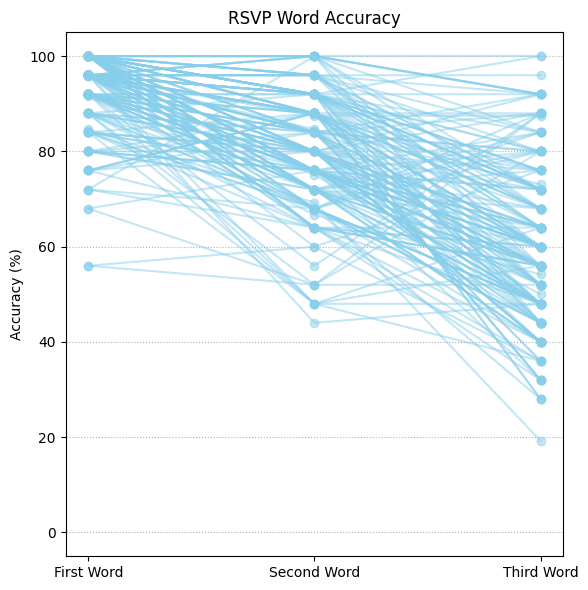

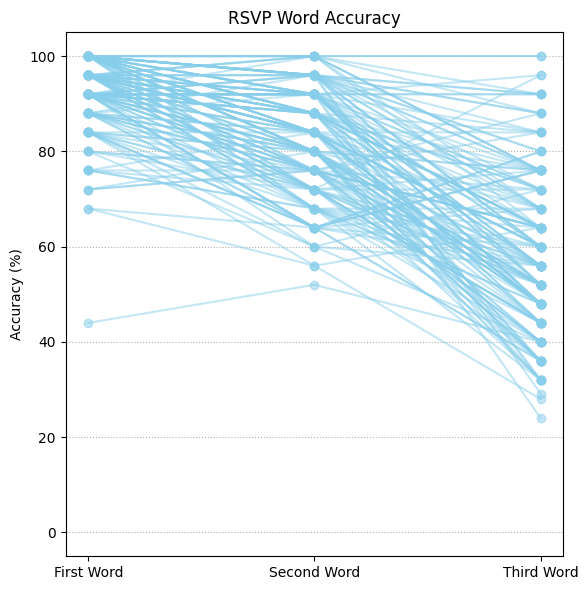

In [77]:
plot_rsvp_word_accuracy_line(df_firstSess_rsvp)
plot_rsvp_word_accuracy_line(df_secondSess_rsvp)

In [79]:
df_firstSess_rsvp['second_over_first'] = df_firstSess_rsvp['secondWord'] / df_firstSess_rsvp['firstWord']
df_secondSess_rsvp['second_over_first'] = df_secondSess_rsvp['secondWord'] / df_secondSess_rsvp['firstWord']

df_firstSess_rsvp['third_over_first'] = df_firstSess_rsvp['thirdWord'] / df_firstSess_rsvp['firstWord']
df_secondSess_rsvp['third_over_first'] = df_secondSess_rsvp['thirdWord'] / df_secondSess_rsvp['firstWord']

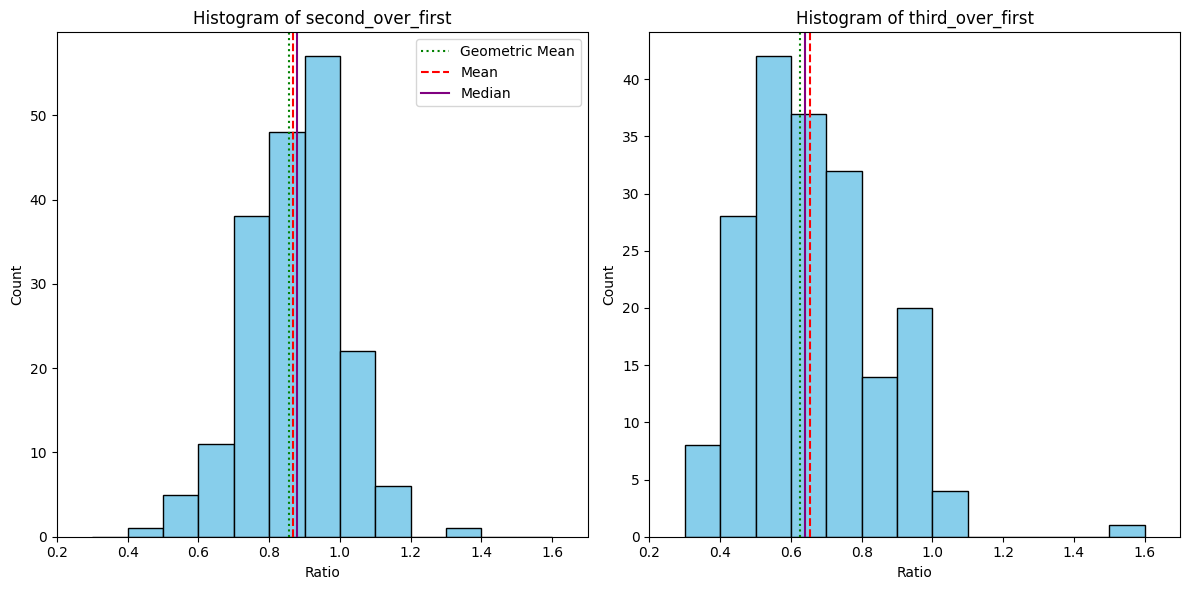

In [93]:

bins = np.linspace(0.3, 1.6, 14)
plt.figure(figsize=(12, 6))
for i, col in enumerate(['second_over_first', 'third_over_first']):
    plt.subplot(1, 2, i+1)
    data = df_firstSess_rsvp[col].dropna()
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Ratio')
    plt.ylabel('Count')
    plt.xlim(0.2, 1.7)
    # plt.yscale('log')
    # plt.ylim(1, 150)
    # Calculate statistics
    mean_val = np.mean(data)
    median_val = np.median(data)
    # For geometric mean, filter out zeros and negatives
    geo_data = data[data > 0]
    if len(geo_data) > 0:
        geom_mean_val = stats.gmean(geo_data)
        plt.axvline(geom_mean_val, color='green', linestyle=':', label='Geometric Mean')
    else:
        geom_mean_val = np.nan
    plt.axvline(mean_val, color='red', linestyle='--', label='Mean')
    plt.axvline(median_val, color='purple', linestyle='-', label='Median')
    # Only show legend on first subplot
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Old codes

In [ ]:
# # merge data frames

# df_all_sessions = pd.concat([df_firstSess, df_firstSess_rsvp, df_firstSess_reading,
#                               df_secondSess, df_secondSess_rsvp, df_secondSess_reading], ignore_index=True)

# # Check if there are any 0 or negative values in df_both_sessions
# if (df_all_sessions['threshold'] <= 0).any().any():
#     print("Check if you wanted to use logged thresholds.")
    
# # only keep participants who completed both sessions
# df_both_sessions = df_all_sessions.groupby("prolificID").filter(lambda g: set(g["repeat"]) == {1, 2, 3, 4})

# num_thresholds_per_subj = 18
# assert df_both_sessions["prolificID"].nunique() == len(df_both_sessions) / num_thresholds_per_subj, 'Fatal: Number of thresholds per subject does not match'

# print(f'\nNumber of participants with both sessions: {df_both_sessions["prolificID"].nunique()}')

# df_both_sessions_log = df_both_sessions.copy()
# df_both_sessions_log['threshold'] = np.log10(df_both_sessions_log['threshold'])
